In [177]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [178]:
codes_list = ['ZCN24.CBT','ZCU24.CBT', 'ZCZ24.CBT','ZCH25.CBT','ZCK25.CBT','ZCN25.CBT','ZCU25.CBT','ZCZ25.CBT','ZCH26.CBT','ZCK26.CBT','ZCN26.CBT','ZCU26.CBT','ZCZ26.CBT']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts until end of 2026), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    dfs_list.append(i_df)


In [179]:
vix_code = '^VIX'
vix_ticker= yf.Ticker(vix_code)

vix_df = vix_ticker.history(start='2020-12-15')
vix_df.index = vix_df.index.date
vix_df['vix'] = vix_df['Close'] 


In [180]:
dow_code = 'YM=F'
dow_ticker = yf.Ticker(dow_code)

dow_df = dow_ticker.history(start = '2020-12-15')
dow_df.index = dow_df.index.date
dow_df['dow'] = dow_df['Close']
#dow jones e-mini continous cbot contracts 
#not a lot of improvement in r^2 but maybe will be better in RF once we get interaction terms

In [181]:
gold_code = 'GC=F'
gold_ticker = yf.Ticker(gold_code)

gold_df = gold_ticker.history(start = '2020-12-15')
gold_df.index = gold_df.index.date
gold_df['gold'] = gold_df['Close']

In [182]:
crude_code = 'CL=F'
crude_ticker = yf.Ticker(crude_code)

crude_df = crude_ticker.history(start = '2020-12-15')
crude_df.index = crude_df.index.date
crude_df['crude'] = crude_df['Close']

In [183]:
# Variables 
for i, df in enumerate(dfs_list):    
    # Daily Returns
    df.index = df.index.date
    df['Returns'] = df['Close'].pct_change() * 100

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-28)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    df = pd.merge(df, vix_df['vix'], left_index=True, right_index=True)
    df = pd.merge(df, dow_df['dow'], left_index=True, right_index=True)
    df = pd.merge(df, gold_df['gold'], left_index=True, right_index=True)
    df = pd.merge(df, crude_df['crude'], left_index=True, right_index=True)


    df = df.dropna()
    dfs_list[i] = df  # Assign the modified df back to the list


dfs_dct = dict(zip(codes_list, dfs_list))

In [184]:
#OLS

def ols(merged_df):
    #Specifying Axes 
    x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP','vix','dow','gold','crude']
    X = merged_df.loc[:, x_vars] #Selecting only from merged_df
    y = merged_df['Month Returns']
    
    #Training and Testing Data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Add constant term to X_train and X_test
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    # Fit the OLS model
    model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
    y_pred = model.predict(X_test) 
    
    #Model Evaluations 

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
    mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
    print(model.summary())
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error(MSE): {mse:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.title('Actual vs Predicted Next Month Returns')
    plt.show()


    X_full = sm.add_constant(X)
    # Make predictions on the entire dataset using the pre-trained model
    y_pred_full = model.predict(X_full)
    
    # Plot actual vs predicted values over time
    plt.figure(figsize=(12, 6))
    plt.plot(merged_df.index, y, label='Actual')
    plt.plot(merged_df.index, y_pred_full, label='Predicted')
    plt.title('Time Series of Actual vs Predicted Next Month Returns')
    plt.xlabel('Date')
    plt.ylabel('Month Returns')
    plt.legend()
    plt.show()

    return model

OLS Summary ZCN24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     18.69
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           9.38e-36
Time:                        12:43:18   Log-Likelihood:                -1186.6
No. Observations:                 411   AIC:                             2403.
Df Residuals:                     396   BIC:                             2464.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

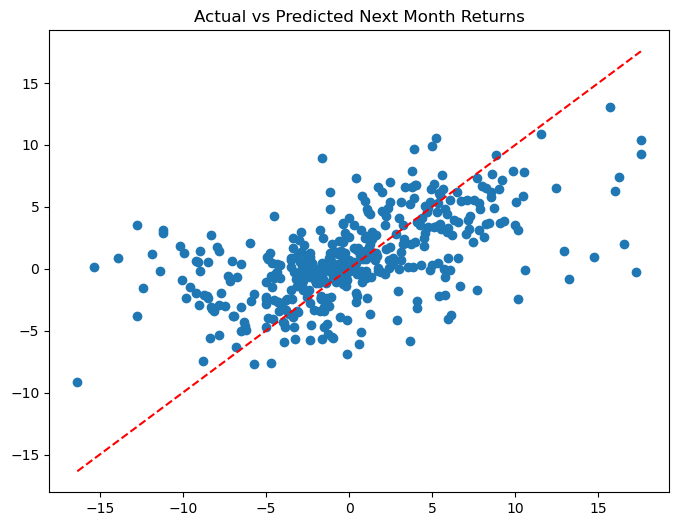

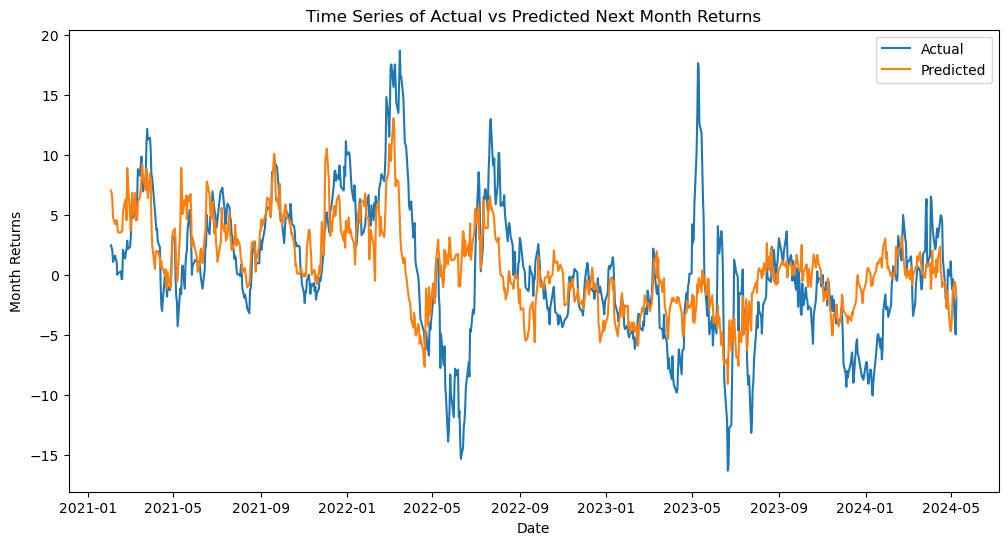



OLS Summary ZCU24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     13.41
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           6.58e-24
Time:                        12:43:18   Log-Likelihood:                -767.07
No. Observations:                 282   AIC:                             1564.
Df Residuals:                     267   BIC:                             1619.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

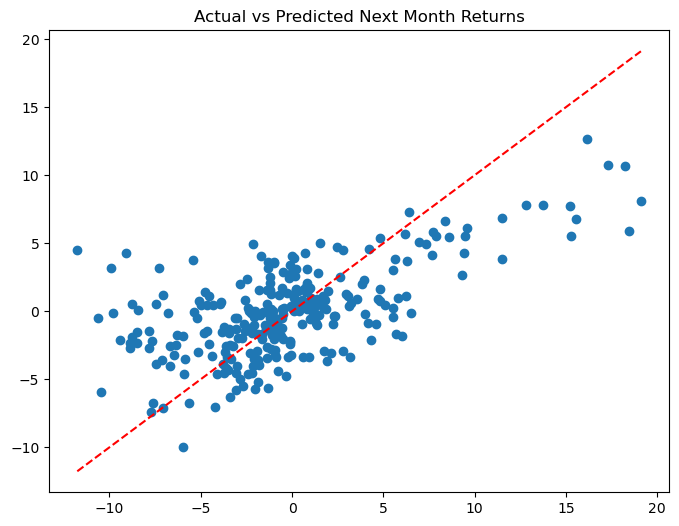

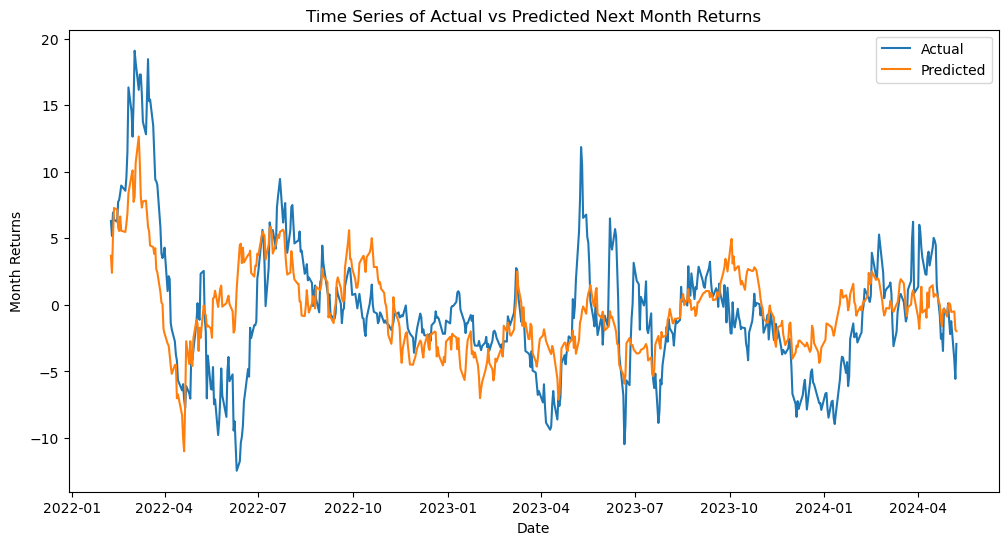



OLS Summary ZCZ24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     20.27
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.74e-38
Time:                        12:43:19   Log-Likelihood:                -1093.2
No. Observations:                 411   AIC:                             2216.
Df Residuals:                     396   BIC:                             2277.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

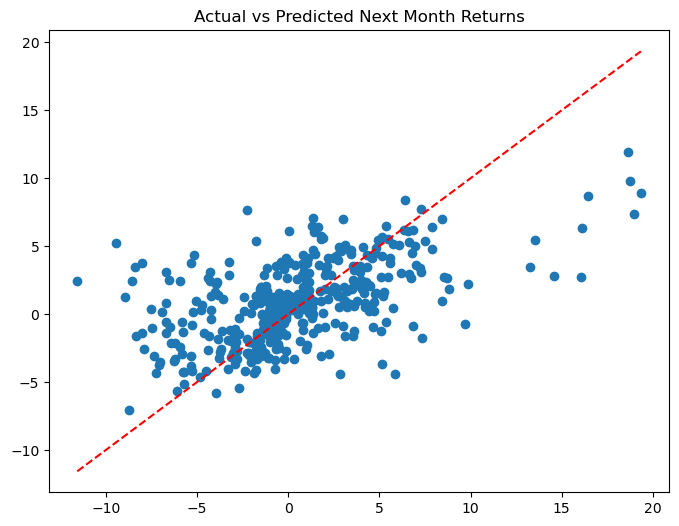

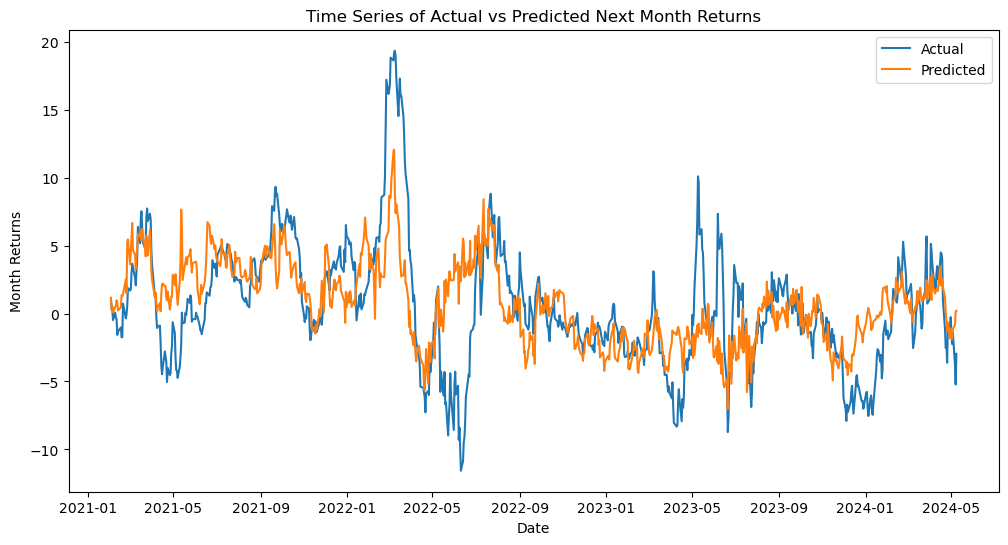



OLS Summary ZCH25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     14.10
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.04e-20
Time:                        12:43:19   Log-Likelihood:                -343.26
No. Observations:                 159   AIC:                             716.5
Df Residuals:                     144   BIC:                             762.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

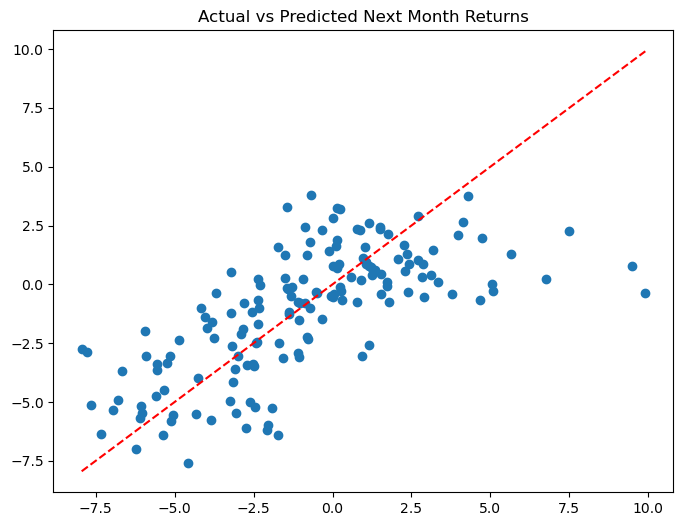

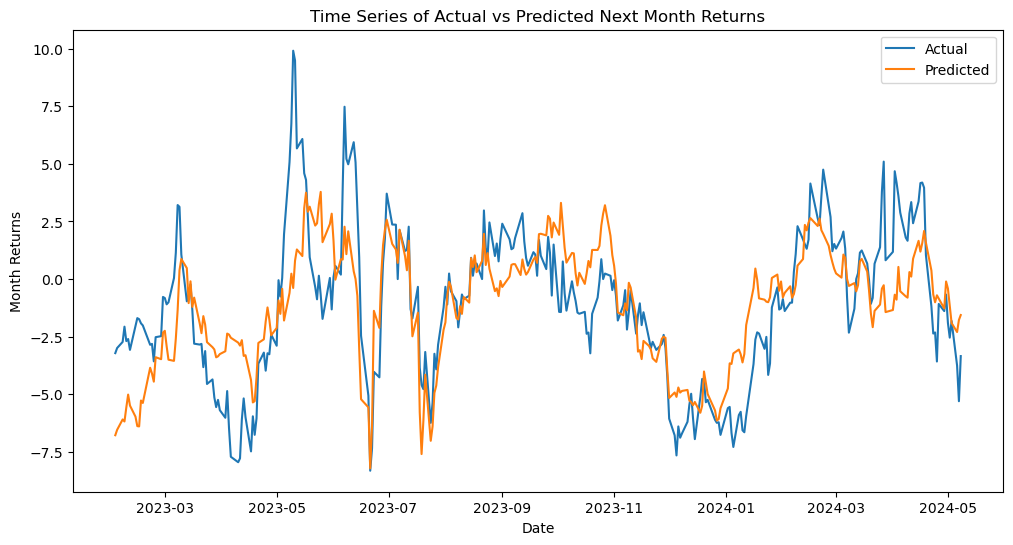



OLS Summary ZCK25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     17.26
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.83e-22
Time:                        12:43:20   Log-Likelihood:                -273.70
No. Observations:                 134   AIC:                             577.4
Df Residuals:                     119   BIC:                             620.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

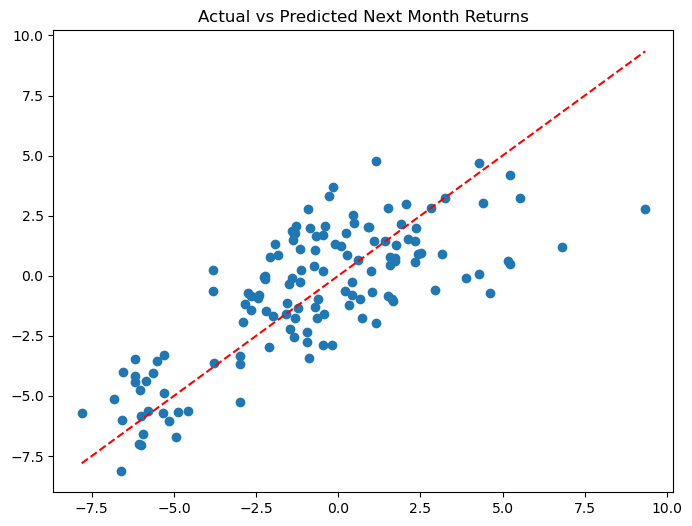

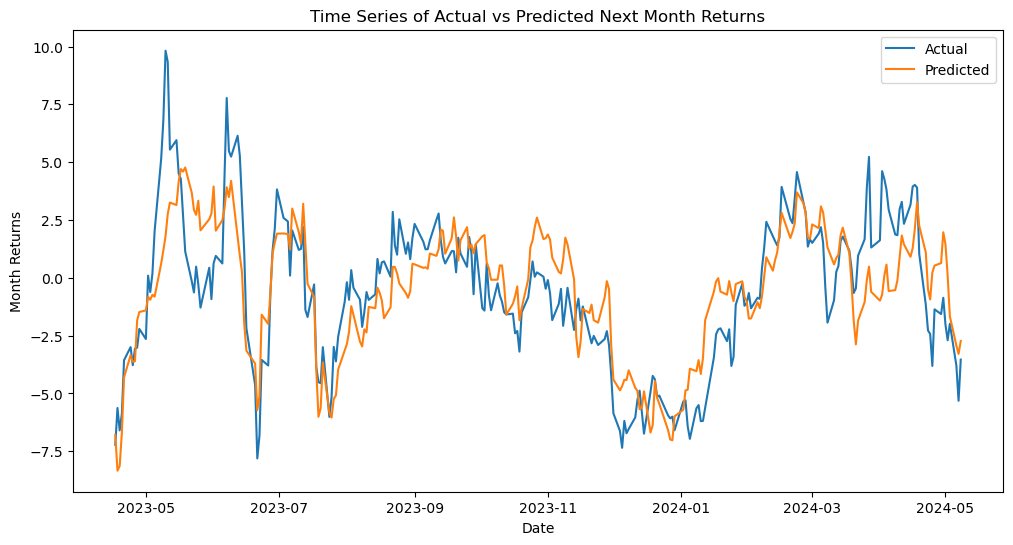



OLS Summary ZCN25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     34.92
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           8.06e-52
Time:                        12:43:20   Log-Likelihood:                -644.80
No. Observations:                 277   AIC:                             1320.
Df Residuals:                     262   BIC:                             1374.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

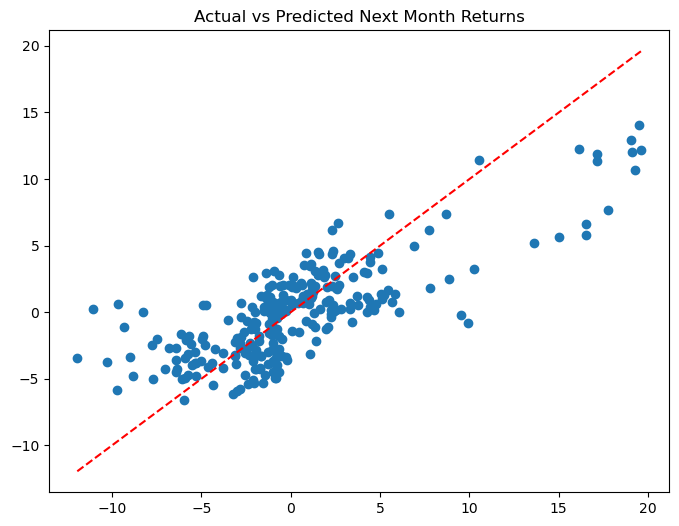

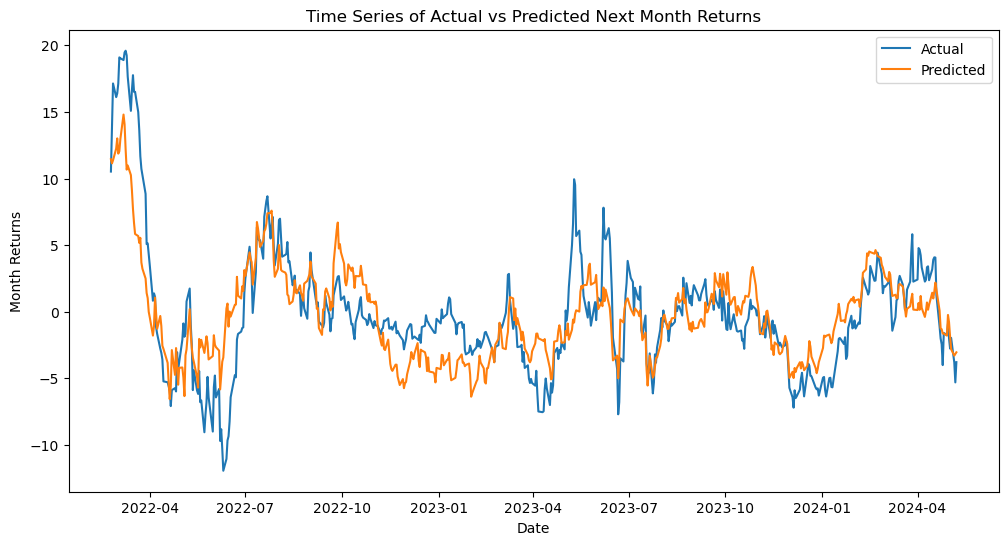



OLS Summary ZCU25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     32.56
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.73e-32
Time:                        12:43:20   Log-Likelihood:                -194.83
No. Observations:                 124   AIC:                             419.7
Df Residuals:                     109   BIC:                             462.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

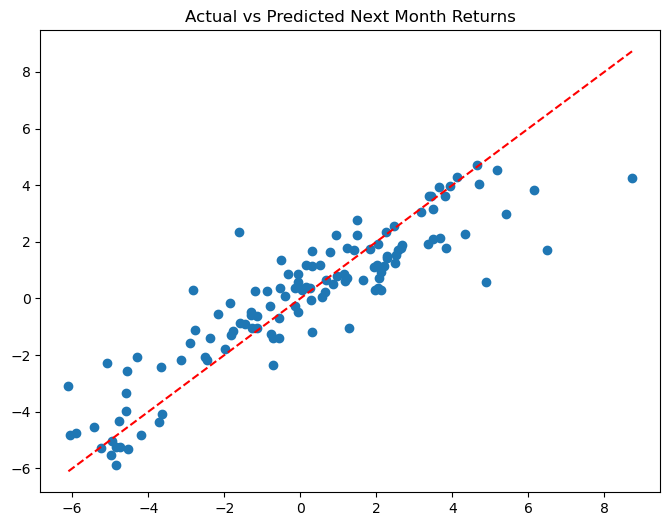

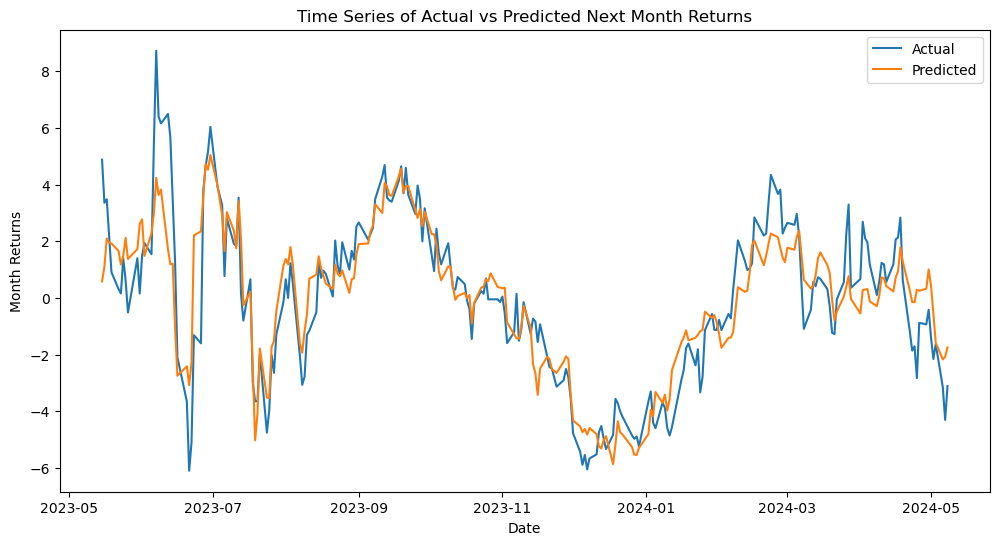



OLS Summary ZCZ25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     46.71
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           9.35e-64
Time:                        12:43:21   Log-Likelihood:                -613.52
No. Observations:                 285   AIC:                             1257.
Df Residuals:                     270   BIC:                             1312.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

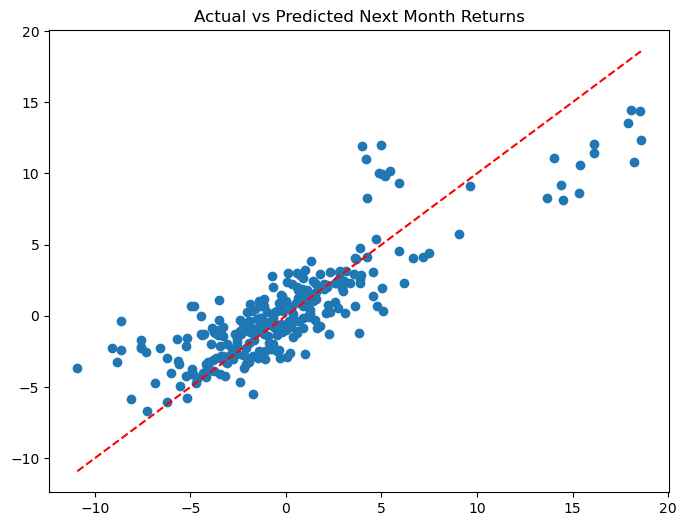

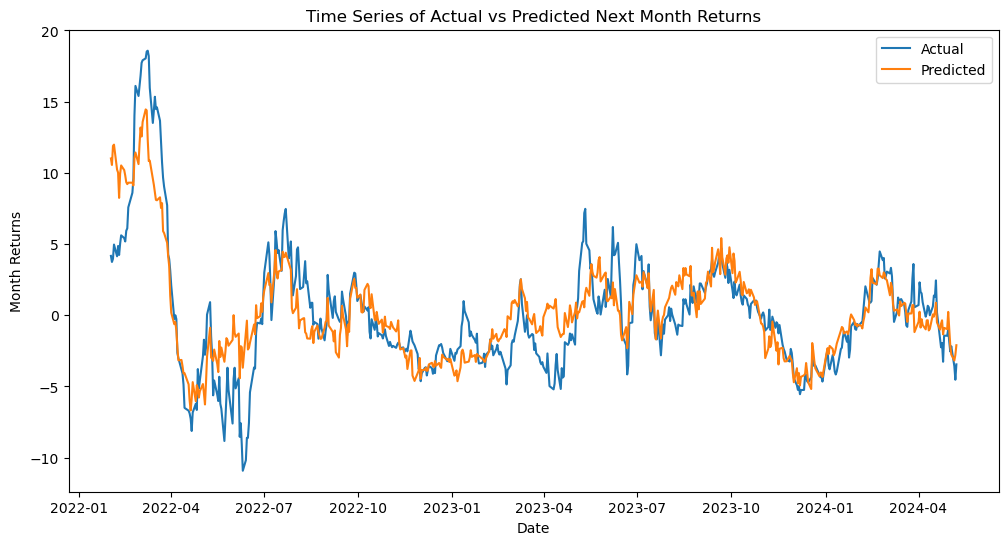



OLS Summary ZCH26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     15.01
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           3.81e-07
Time:                        12:43:21   Log-Likelihood:                -30.423
No. Observations:                  33   AIC:                             90.85
Df Residuals:                      18   BIC:                             113.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

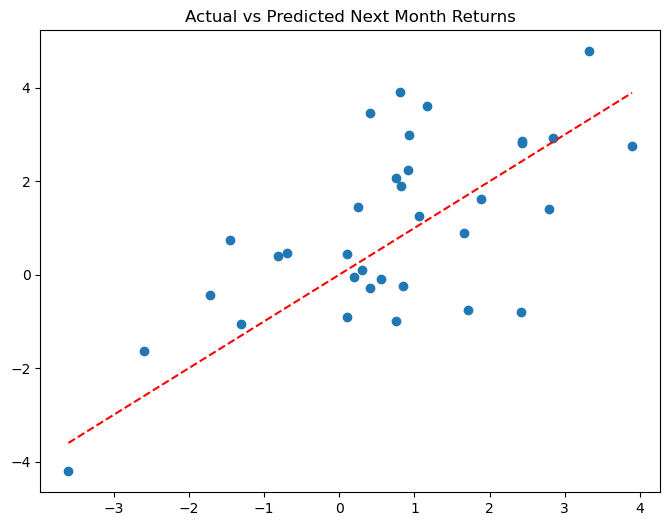

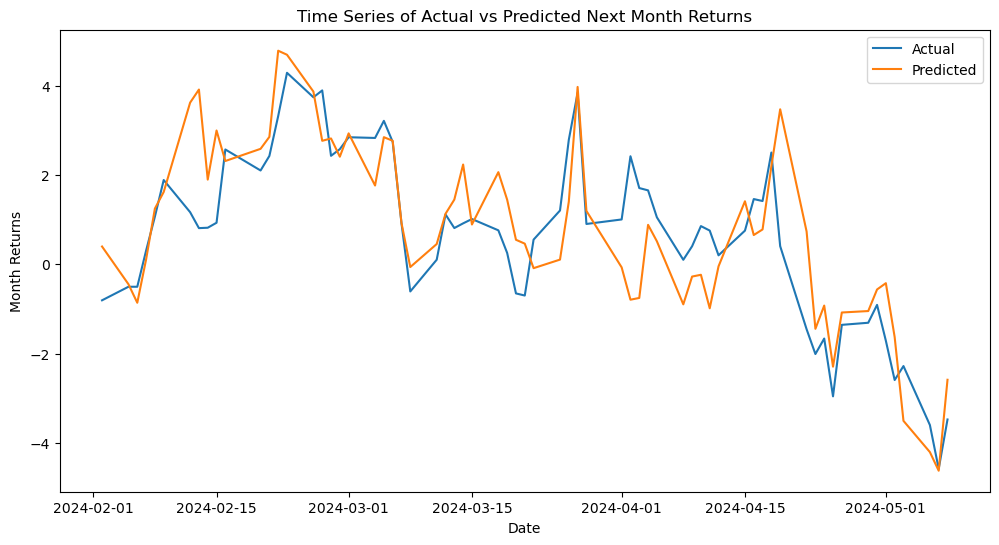



OLS Summary ZCK26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     23.32
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.09e-08
Time:                        12:43:21   Log-Likelihood:                -14.608
No. Observations:                  33   AIC:                             59.22
Df Residuals:                      18   BIC:                             81.66
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

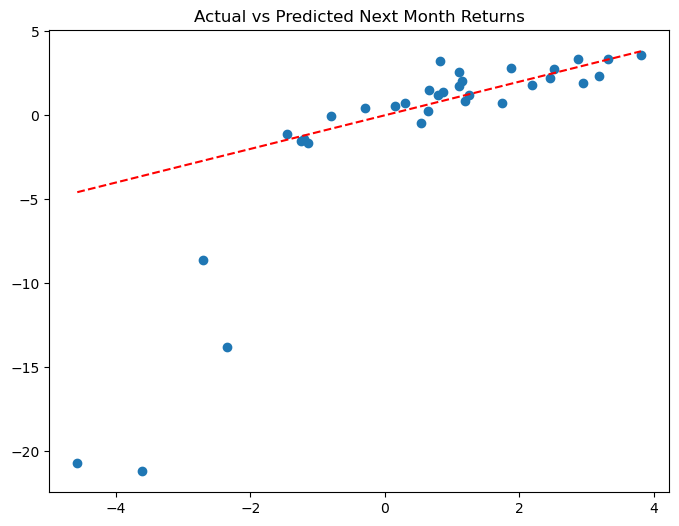

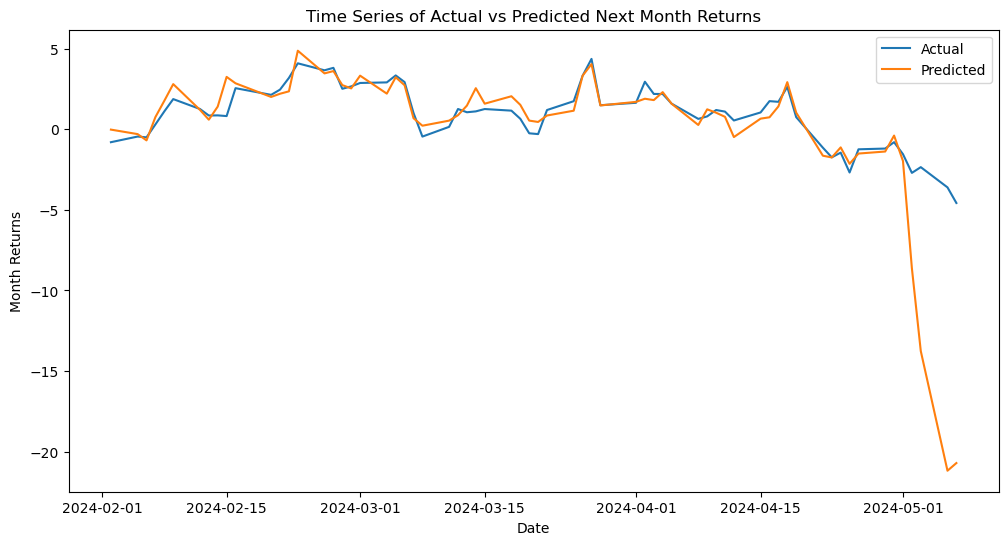



OLS Summary ZCN26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     55.40
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           3.82e-43
Time:                        12:43:22   Log-Likelihood:                -164.06
No. Observations:                 125   AIC:                             358.1
Df Residuals:                     110   BIC:                             400.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

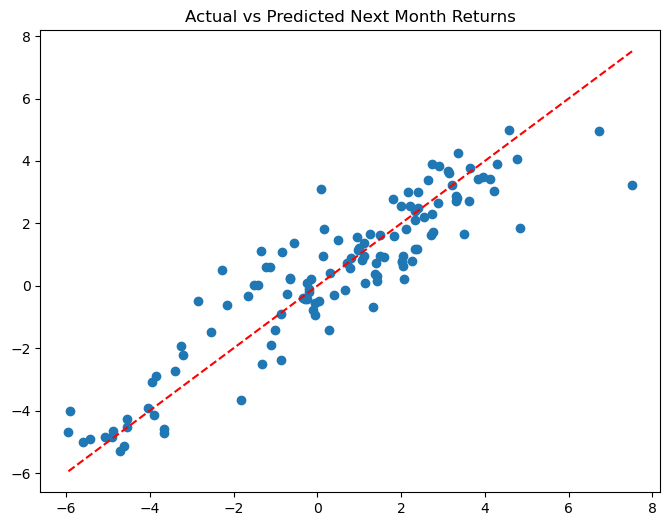

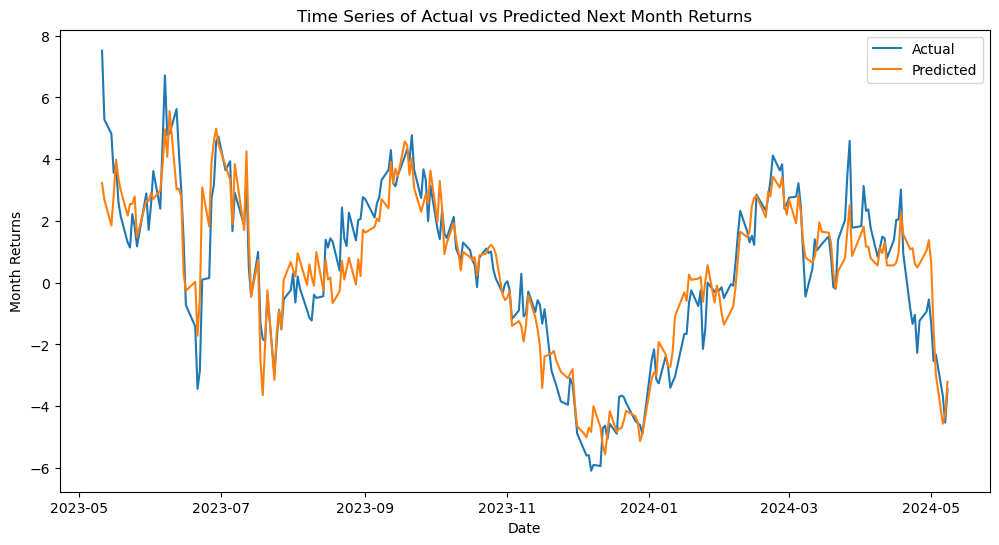



OLS Summary ZCU26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     25.23
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           5.67e-09
Time:                        12:43:22   Log-Likelihood:                -11.666
No. Observations:                  33   AIC:                             53.33
Df Residuals:                      18   BIC:                             75.78
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

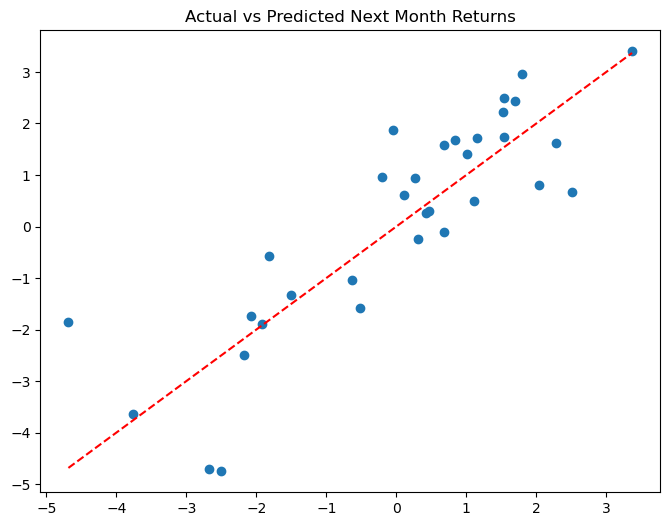

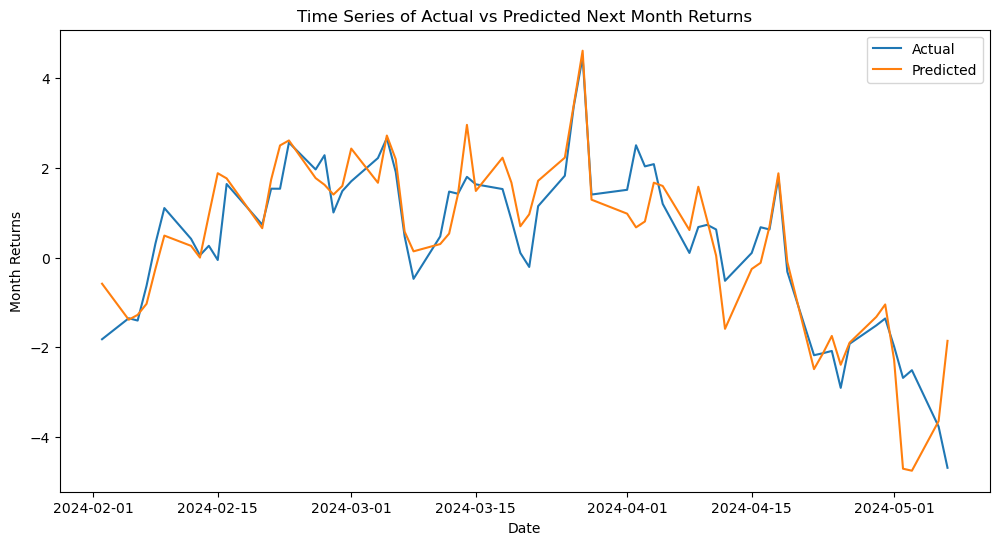



OLS Summary ZCZ26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     19.17
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           2.56e-26
Time:                        12:43:23   Log-Likelihood:                -294.45
No. Observations:                 159   AIC:                             618.9
Df Residuals:                     144   BIC:                             664.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

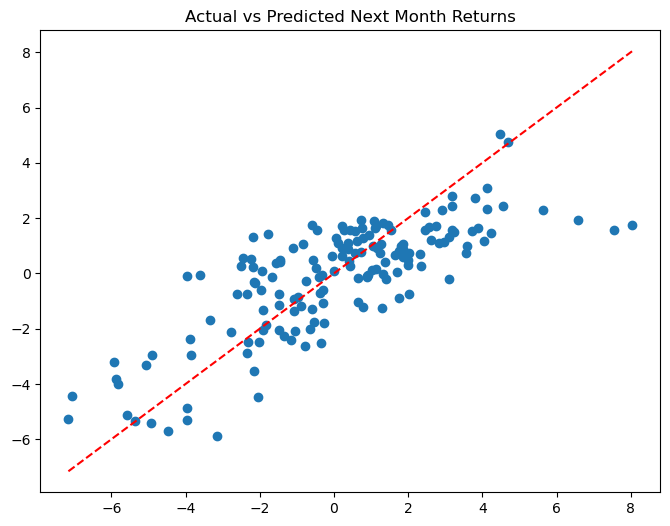

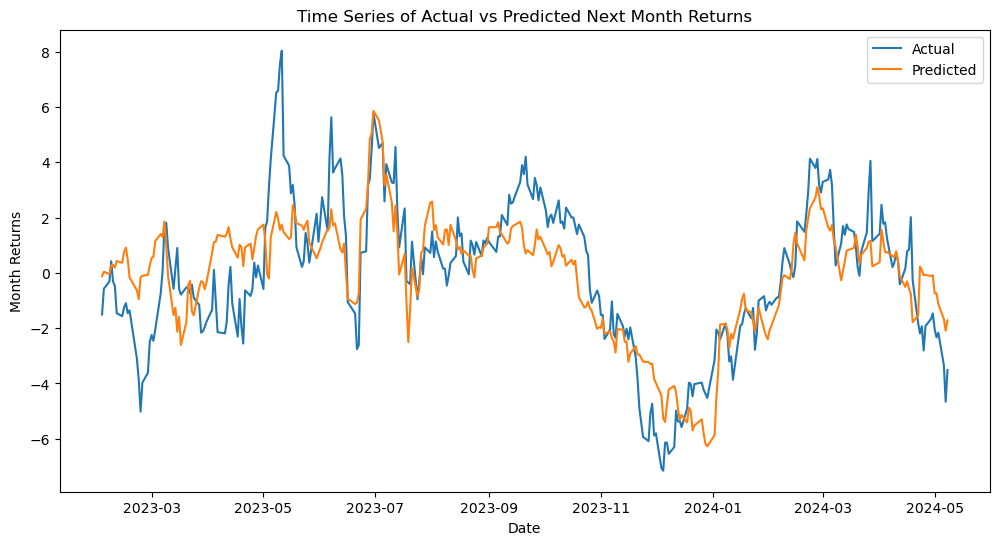

In [185]:
#Inputs for OLS 
OLS_models_dict = {}
for name, df in dfs_dct.items():
    print(f'OLS Summary {name}:')
    ols_model = ols(df)
    OLS_models_dict[name] = ols_model  # Store the ols model object in the dictionary
#so in OLS_models_dict we have the name of the contracts as key and the regression object as val
#so that we can create a trading strat based on the next month expected returns
    print('\n')

In [186]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [187]:
# Visualization: Actual vs Predicted
'''
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')\nplt.xlabel('Actual')\nplt.ylabel('Predicted')\nplt.title('Actual vs Predicted')\nplt.show()\n"

In [188]:
'''
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")
'''

'\n# Set up Optuna study\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=50)\n\n# Get the best hyperparameters\nbest_params = study.best_params\n\n# Train the model with the best hyperparameters\nrf_best = RandomForestRegressor(**best_params, random_state=42)\nrf_best.fit(X_train, y_train)\n\n# Evaluate the model\ny_pred = rf_best.predict(X_test)\nmae = mean_absolute_error(y_test, y_pred)\nrmse = root_mean_squared_error(y_test, y_pred)\nmse = mean_squared_error(y_test, y_pred)\n\nprint(f"Best Hyperparameters: {best_params}")\nprint(f"Mean Absolute Error (MAE): {mae:.2f}")\nprint(f"Root Mean Squared Error (RMSE): {rmse:.2f}")\nprint(f"Mean Squared Error(MSE): {mse:.2f}")\n'

In [189]:
'''
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

'\n# Visualization: Feature Importance\nfeature_importances = rf_best.feature_importances_\nsorted_indices = np.argsort(feature_importances)[::-1]\nplt.figure(figsize=(10, 6))\nplt.title("Feature Importances")\nplt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")\nplt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)\nplt.tight_layout()\nplt.show()\n\n# Visualization: Actual vs Predicted\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], \'--\', color=\'red\')\nplt.xlabel(\'Actual\')\nplt.ylabel(\'Predicted\')\nplt.title(\'Actual vs Predicted\')\nplt.show()\n'